# Project: Travel Insurance Prediction

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, chi2_contingency, loguniform, randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler

In [92]:
path = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint1\project\travel_insurance.csv"

travelin = pd.read_csv(path)

In [93]:
travelin.head(3)

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1


In [94]:
travelin.tail(3)

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
1984,1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0
1985,1985,34,Private Sector/Self Employed,Yes,1000000,6,0,Yes,Yes,1
1986,1986,34,Private Sector/Self Employed,Yes,500000,4,0,No,No,0


We can see that there is unnecessary column "unnamed", I removed  
it from dataframe because it has no true value for analysis.

In [95]:
travelin = travelin.drop(columns=travelin.columns[0])

In [96]:
travelin = sand.cleaner(travelin)
travelin = travelin.rename(columns={"employment type":"employment_type"})

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: True
Is there any NaN numbers?: False
Is there any empty cells?: False


I checked what kind of duplicates occurs

In [97]:
travelin[travelin.duplicated(keep="first")]

,age,employment_type,graduateornot,annualincome,familymembers,chronicdiseases,frequentflyer,evertravelledabroad,travelinsurance
69,31,Government Sector,No,300000,4,0,No,No,0
103,26,Private Sector/Self Employed,Yes,1400000,5,0,No,Yes,1
117,31,Government Sector,Yes,400000,5,0,No,No,0
148,25,Private Sector/Self Employed,Yes,1400000,4,0,No,Yes,1
164,28,Government Sector,Yes,300000,6,0,No,No,0
...,...,...,...,...,...,...,...,...,...
1978,34,Private Sector/Self Employed,Yes,700000,5,0,No,No,1
1979,28,Private Sector/Self Employed,Yes,1100000,4,1,No,No,0
1980,25,Private Sector/Self Employed,No,1150000,5,1,No,No,0
1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0


Because most of the data are binary categorical, duplicates might occur and doesn't  
need to be removed for this dataset

## Exploratory Data Analysis (EDA)

I looked at the data types of every features, row/column number

In [98]:
travelin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  1987 non-null   int64 
 1   employment_type      1987 non-null   object
 2   graduateornot        1987 non-null   object
 3   annualincome         1987 non-null   int64 
 4   familymembers        1987 non-null   int64 
 5   chronicdiseases      1987 non-null   int64 
 6   frequentflyer        1987 non-null   object
 7   evertravelledabroad  1987 non-null   object
 8   travelinsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


- Employment type: could be changed to 0 and 1 (private=0, gov=1)  
- Graduate or Not: could be changed to 0 and 1 (no=0, yes=1) 
- Frequent flier: could be changed to 0 and 1 (no=0, yes=1)  
- Ever travelled abroad: could be changed to 0 and 1 (no=0, yes=1)

It is good practice to check what unique values has dataframe.  
This might give some insights on how to structurize data for  
the following analysis.

In [99]:
columns = len(travelin.columns)

for col in range(columns):
    print(f"{travelin.columns[col]}: {travelin.iloc[:,col].unique()}")

age: [31 34 28 25 33 26 32 29 35 30 27]
employment_type: ['Government Sector' 'Private Sector/Self Employed']
graduateornot: ['Yes' 'No']
annualincome: [ 400000 1250000  500000  700000 1150000 1300000 1350000 1450000  800000
 1400000  850000 1500000 1050000  350000 1100000  600000  900000  550000
  300000  750000 1200000 1000000  950000 1700000 1750000  650000  450000
 1650000 1800000 1550000]
familymembers: [6 7 4 3 8 9 5 2]
chronicdiseases: [1 0]
frequentflyer: ['No' 'Yes']
evertravelledabroad: ['No' 'Yes']
travelinsurance: [0 1]


Depending on a given rezult, values of several features will be  
transferred to 0's/1's bias type. Additionally, annual income will be  
changed to millions in order to shorten numbers lenght.

In [100]:
travelin = travelin.copy()
travelin["graduateornot"] = travelin["graduateornot"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["frequentflyer"] = travelin["frequentflyer"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["evertravelledabroad"] = travelin["evertravelledabroad"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["employment_type"] = travelin["employment_type"].apply(
    lambda x: 0 if x == "Private Sector/Self Employed" else 1
)
travelin["annualincome"] = travelin["annualincome"].apply(
    lambda x: x / 1000000
)

With function .describe() we check numeric type features

In [101]:
travelin.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1987.0,29.650226,2.913308,25.0,28.0,29.0,32.00,35.0
employment_type,1987.0,0.286865,0.452412,0.0,0.0,0.0,1.00,1.0
graduateornot,1987.0,0.851535,0.355650,0.0,1.0,1.0,1.00,1.0
annualincome,1987.0,0.932763,0.376856,0.3,0.6,0.9,1.25,1.8
familymembers,1987.0,4.752894,1.609650,2.0,4.0,5.0,6.00,9.0
chronicdiseases,1987.0,0.277806,0.448030,0.0,0.0,0.0,1.00,1.0
frequentflyer,1987.0,0.209864,0.407314,0.0,0.0,0.0,0.00,1.0
evertravelledabroad,1987.0,0.191243,0.393379,0.0,0.0,0.0,0.00,1.0
travelinsurance,1987.0,0.357323,0.479332,0.0,0.0,0.0,1.00,1.0


We have customers between 25 and 35 years. Most of the customers are graduated college  
and average anual income is about 932k rupees. Customer's family consists of min 2  
family members to max 9.

Now we have two types of data:  
- numeric continuous: age, annualincome  
- categorical: where employment type, graduate/not, chronic diseases,  
frequentflyer, ever travelled abroad, travelinsurance are discrete binary  
and family members standard discrete.  
With this info we can make two dataframes for both types.

In [102]:
travel_num = travelin[["age", "annualincome", "familymembers", "travelinsurance"]]
travel_cate = travelin[
    [
        "employment_type",
        "graduateornot",
        "familymembers",
        "chronicdiseases",
        "frequentflyer",
        "evertravelledabroad",
        "travelinsurance",
    ]
]

Let's analyse target feature - travel insurance. Since it is  
binary categorical data, I will first count each category and  
then plot them for a visual representation.

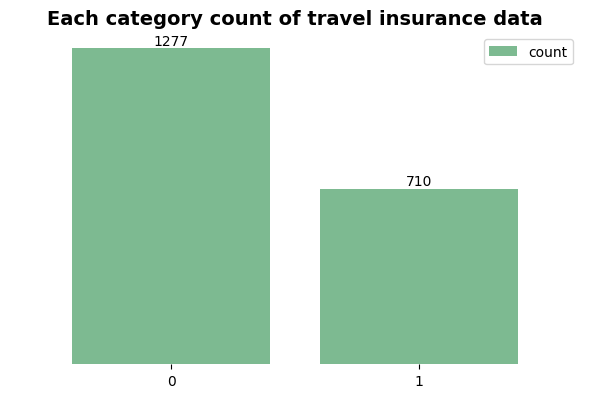

In [103]:
travel_counts = travel_cate["travelinsurance"].value_counts()
sand.f_barplot(travel_counts, title="Each category count of travel insurance data")

It can be clearly seen, that there is more instances for the 0's  
(where people didn't buy travel insurance) than 1's (where people  
did buy travel insurance)

In [104]:
counted = travelin["travelinsurance"].value_counts()
counted.apply(lambda x: round(x / counted.sum(), 2))

travelinsurance
0    0.64
1    0.36
Name: count, dtype: float64

Percently, only 36% of people tend to take travel insurance  
while 64% doesn't.

To analyse features of binary data I have plotted 5 count  
subplots to one huge plot.

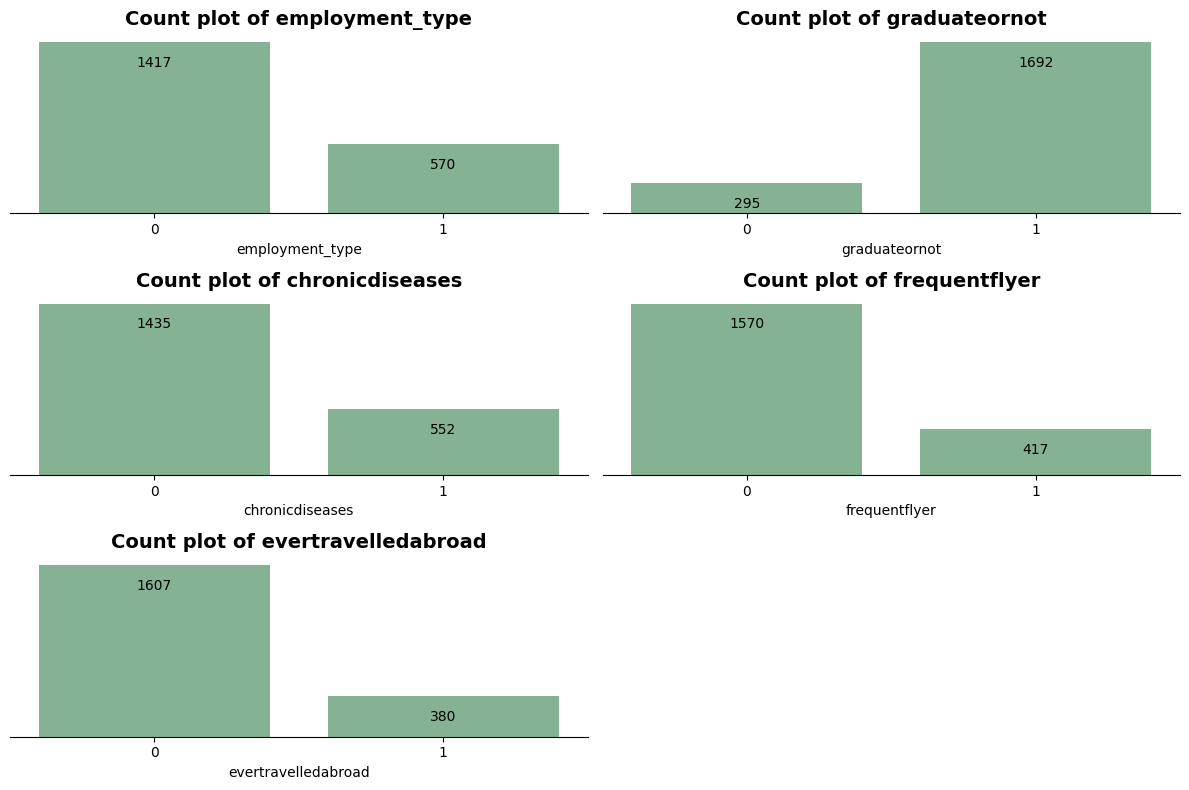

In [105]:
nums = travel_cate.drop(columns=["familymembers", "travelinsurance"])
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
ax = ax.flatten()
for axis, col in zip(ax, list(nums.columns)):
    sns.countplot(data=nums, x=col, ax=axis)
    for container in axis.containers:
        axis.bar_label(container, padding=-20)
    axis.axes.get_yaxis().set_visible(False)
    axis.axes.get_xaxis().set_visible(True)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_xlabel(col)
    axis.set_ylabel("Count")
    axis.set_title(f"Count plot of {col}", size=14, fontweight="bold", ha="center")
if len(list(nums.columns)) < len(ax):
    fig.delaxes(ax[-1])
plt.tight_layout()

plt.show()

One main pattern could be seen of these plots is that none of each has  
similar count data of 0's and 1's meaning some parts of the data might  
be imbalanced and have impact to ML algorithms.  
Talking about each feature:  
- Employment type: government sector is less populated than private;  
- Graduate or not: much more people are graduated;  
- Chronic diseases: less people has chronic diseases;  
- Frequent flyer: there aren't many peoler who flyes frequently;  
- Ever travelled abroad: and as well not many travelled abroad.

Data shows that there are less frequent flyers, but I would like to  
know if frequent flyers tend to purchase travel insurance more likely?  
For this question to answer, I performed chi-squared null hypothesis:  
alpha = 0.05  
**H0:** *p > 0.05 frequent flyers does not buy travel insurance more.*  
**Ha:** *p < 0.05 frequent flyers does buy travel insurance more.*

In [106]:
contingency_table = pd.crosstab(travelin["frequentflyer"], travelin["travelinsurance"])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 test result: {chi2}\np-value: {p}")

Chi2 test result: 105.85723074203977
p-value: 7.92436041506454e-25


We can see that p-value is less than 0.05 and we have to  
reject null hypothesis, meaning that frequent flyers does buy  
travel insurance more likely.

I also wanted to look frequent flyers dependency on private and  
government sectors.

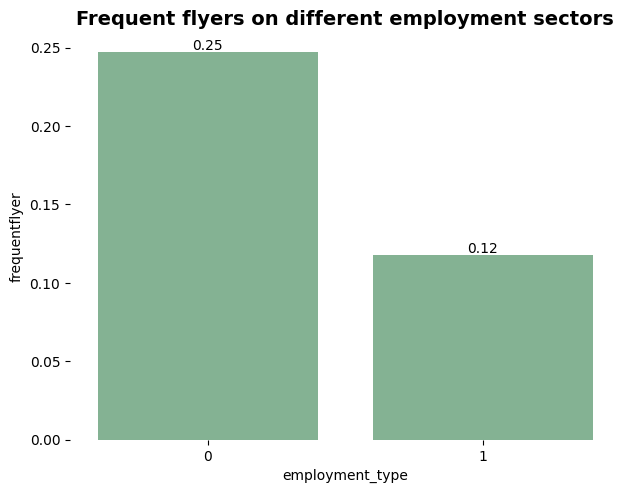

In [107]:
def barplt(data=None, x=None, y=None, hue=None):
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, errorbar=None)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f")
    ax.axes.get_yaxis().set_visible(True)
    ax.axes.get_xaxis().set_visible(True)
    ax.set_frame_on(False)
    plt.tight_layout()
    plt.title(
        "Frequent flyers on different employment sectors",
        size=14,
        fontweight="bold",
        ha="center")

barplt(data=travel_cate, x="employment_type", y="frequentflyer")

It can be seen that private sector has two times more frequent flyers than  
government. Still we have keep in mind that people who frequently flyes  
by planes are strongly less than those who doesn't fly meaning less reliability  
of the given data.

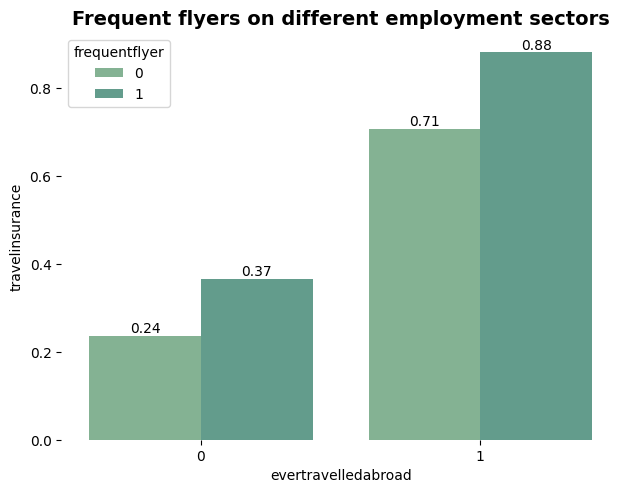

In [108]:
barplt(data=travel_cate, x="evertravelledabroad", y="travelinsurance", hue="frequentflyer")

Plot shows that people who have travelled abroad atleast once is more  
likely to take travel insurance. Frequent flyers uses  
travel insurance even more despite they have or not ever travelled abroad.  
This tendency seems logical because people tend to protect themselves and  
belongings more when traveling.

Now let's analyse numeric features and look at the distribution  
of age by travel insurance

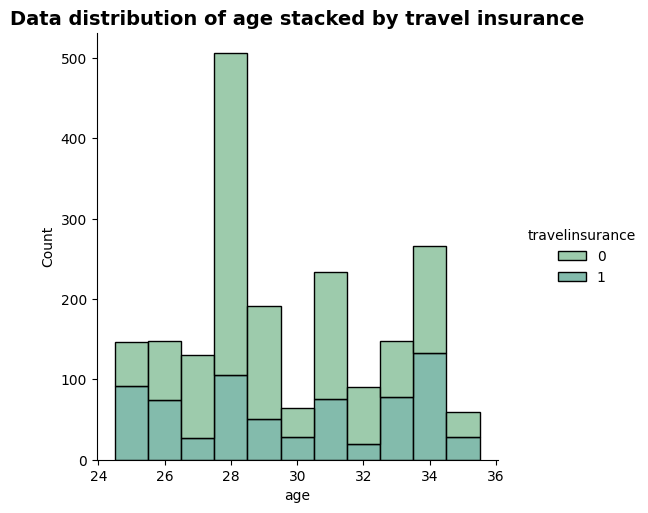

In [109]:
sns.displot(
    travel_num, x="age", hue="travelinsurance", multiple="stack", discrete=True
)
plt.title(
    "Data distribution of age stacked by travel insurance",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.show()

It can be seen that data is not distributed normally. Most data points collected  
from 28 year old people. People from 25 to 26 years tend to take travel insurance  
more likely than 27-32, also from 33 interest for travel insurance is higher too.

Secondly, let's look at the annual income and how it distributes

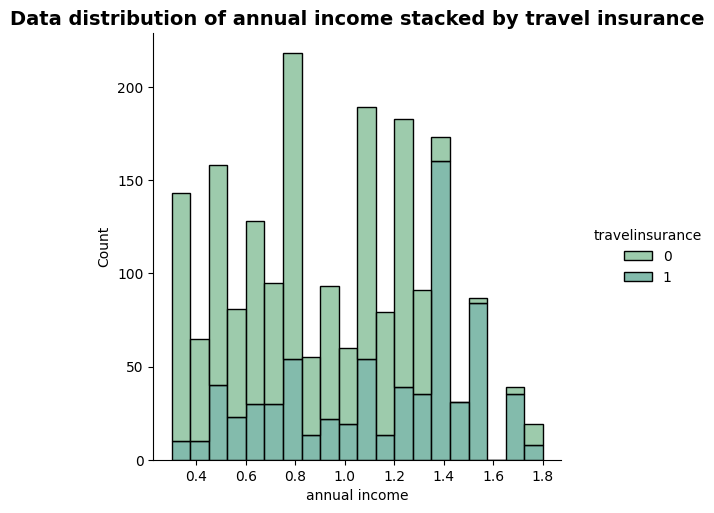

In [110]:
sns.displot(
    travel_num, x="annualincome", hue="travelinsurance", multiple="stack", bins=20
)
plt.title(
    "Data distribution of annual income stacked by travel insurance",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.xlabel("annual income")
plt.show()

Greener bars shows that annual income > 1.3M is the threshold for people  
to take travel insurance. Despite lower income, some of the people  
takes insurance too.

We can also look at the age of people, which have annual income > 1.3M.  
Guessing is that higher age people have higher income.  
To check it, I made new dataframe only with > 1.3M annual income data points.

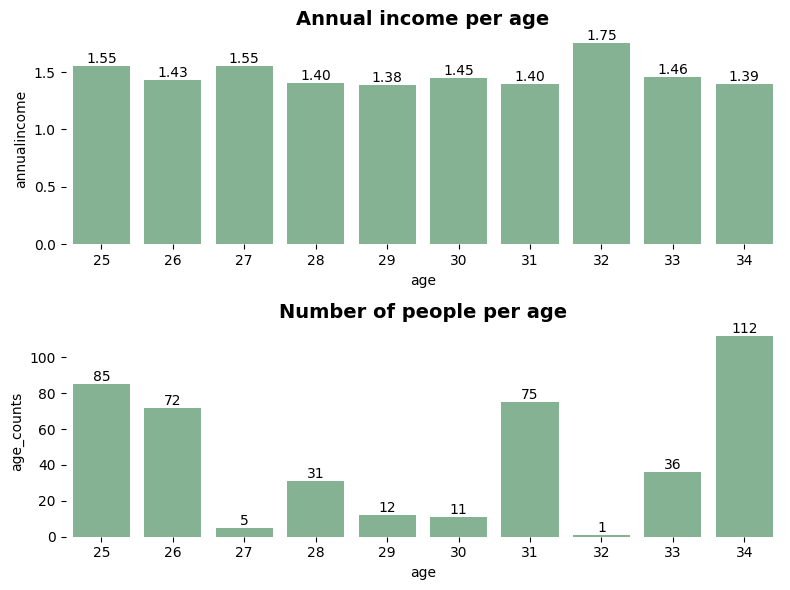

In [111]:
travel_num_13 = travel_num[travel_num["annualincome"] >= 1.3]
age_counts = travel_num_13.groupby("age").agg({"annualincome":"mean", "age":"count"}).rename(columns=({"age":"age_counts"}))
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
splot = sns.barplot(data=age_counts, x=age_counts.index, y="annualincome", errorbar=None, ax=ax[0])
for container in splot.containers:
    splot.bar_label(container, fmt="%.2f")
splot.set_frame_on(False)

bplot = sns.barplot(data=age_counts, x=age_counts.index, y="age_counts", errorbar=None, ax=ax[1])
for container in bplot.containers:
    bplot.bar_label(container, fmt="%.0f")
bplot.set_frame_on(False)
splot.set_title(
    "Annual income per age",
    size=14,
    fontweight="bold",
    ha="center"
)
bplot.set_title(
    "Number of people per age",
    size=14,
    fontweight="bold",
    ha="center"
)
plt.tight_layout()
plt.show()

Apparently, we can see that annual income is very similar through  
whole age scale. Only 32 year old person tend to receive more (~1.75M).  
Due to very low number of age counts for age 32, this particular sample  
is not reliable and could be treated as anomaly.

I also check family members impact to travel insurance provided  
by data to see data distribution and how family chooses  
to take travel insurance or not by it's size.

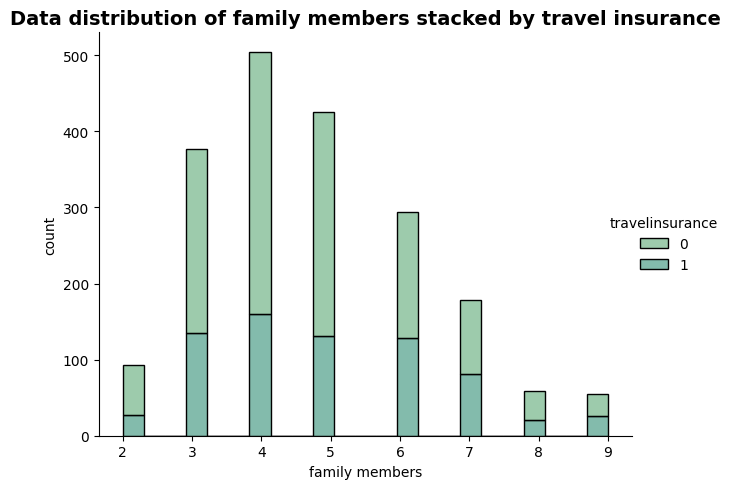

In [112]:
import functions_sandbox as sand
sand.f_displot(
    data=travel_cate,
    xaxis="familymembers",
    hue="travelinsurance",
    multiple="stack",
    xlabel="family members",
    ylabel="count",
    title="Data distribution of family members stacked by travel insurance"
)

Visualized data shows that families consisted of 3-5 members are  
very popular where 4 is the most popular. Above 5 members tendency decreases.  
Interestingly, families with higher number of members tend to  
take travel insurance more.

Talking about data distribution of this particular feature, data is almost  
normally distributed with a little skew to the right. To get more asurance  
if data is normally distributed, Shapiro-Wilk test was performed with null hypothesis  
was performed:
alpha = 0.05  
**H0:** *p > 0.05 suggests that the data is normally distributed.*  
**Ha:** *p < 0.05 data isn't distributed norally.*

In [113]:
stat, p = shapiro(travel_cate["familymembers"])
print(f"Statistics = {stat:.4f} \np = {p}")
print(f"Skewness = {travel_cate['familymembers'].skew():.4f}")

Statistics = 0.9381 
p = 5.028923273710711e-28
Skewness = 0.5612


With the given results (p < 0.05) we must to **reject null hypothesis** implying  
that family members data distribution is not distributed normally.

I wanted to check if family members number has impact to travel  
insurance purchace and because family members data distribution is  
not normal, Logistic regression null hypothesis will fit in to answer  
this question.
*alpha = 0.05*  
**H0:** *p > 0.05 there is no statistical association between family size  
and travel insurance*  
**Ha:** *p < 0.05 there is statistical association between family size  
and travel insurance*

In [114]:
X = travelin[["familymembers"]]
y = travelin["travelinsurance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print(f"Coefficient for family size: {log_reg.coef_[0][0]}")
print(f"Intercept: {log_reg.intercept_[0]}")

X_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_const)
result = logit_model.fit()

print(result.summary())

Coefficient for family size: 0.1500583138467693
Intercept: -0.5867337996554607
Optimization terminated successfully.
         Current function value: 0.649691
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        travelinsurance   No. Observations:                 1589
Model:                          Logit   Df Residuals:                     1587
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                0.004014
Time:                        17:30:31   Log-Likelihood:                -1032.4
converged:                       True   LL-Null:                       -1036.5
Covariance Type:            nonrobust   LLR p-value:                  0.003918
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5868      0.

The result shows that p>|z| is lower than 0.05 meaning we have to reject  
null hypothesis. This indicates that there is a statistically signifiacant  
association between family size and the purchate of travel insurance. Also,  
confidence interval (CI) does not include zero (-0.690, -0.484).

I also wanted to check overall correlation of whole dataframe features.  
For that I have prepared dataframe and converted some of the categorical  
features to numeric binary.  
I used spearman's correlation matrix because it ables to compute binary  
and continuous data, work with non normally distributed data, non-linear  
relationships.

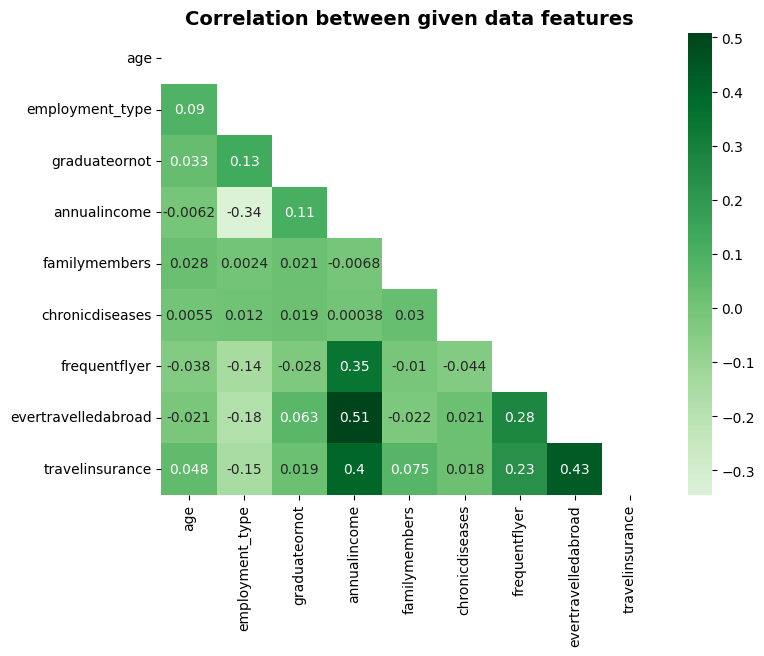

In [115]:
spearmans_corr = travelin.corr(method="spearman")
sand.f_heatmap(spearmans_corr, figsize=(8, 6), title="Correlation between given data features")

Most of relationships between features of heatmap are too weak  
to state it's correlated, but there is "evertravelledabroad"-"annualincome",  
"travelinsurance"-"annualincome" and "travelinsurance"-"evertravelledabroad"  
which shows correlative sights due it's higher correlation number.  
Because my further analysis target will be travel insurance, non correlative  
predictors between each other is a benefit for predictions:  
- Reduces redundancy;  
- Reduces multicollinearity;  
- Helps to avoid overfitting;  
- Simplifies model interpretation.

## ML predictions

For Machine Learning (ML) I have used three type of models:  
- LogisticRegression (linear model);
- HistGradientBoostingClassifier (non-linear model);  
- RandomForestClassifier (non-linear model).  
Firstly, I have prepared my data X - predictor and y - target. I also splitted  
my data into train (75%) and test (25%).  

In [116]:
# prediction target (y) and features (X)
X = travelin.drop("travelinsurance", axis=1)
y = travelin["travelinsurance"]

# oversampling
oversampler = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X, y) # must to oversample only 75% not the whole dataset

# features' types
numerical = travelin[["age", "annualincome", "familymembers"]]
categorical = travelin[["employment_type", "graduateornot", "chronicdiseases", "frequentflyer", "evertravelledabroad"]]

# train/test splitting
data_train, data_test, target_train, target_test = train_test_split(
    X, y, random_state=42
)

# Scaling numeric data
scaler = StandardScaler().set_output(transform="pandas")

After basic data preparation is done, pipeline creation comes next.  
Because my data consists only of numeric values, I didn't use preprocessor  
for OneHotEncoder() + StandardScaler().  
I used 3 types of models on standard dataset and oversampled to check the  
impact when target samples are equaly proportioned.

In [117]:
# Making pipeline
model_reg = make_pipeline(scaler, LogisticRegression(max_iter=500))
model_gboost = Pipeline([("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model_rforest = Pipeline([("classifier", RandomForestClassifier(random_state=42))])

model_reg_oversampled = make_pipeline(scaler, LogisticRegression(max_iter=500))
model_gboost_oversampled = Pipeline([("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])
model_rforest_oversampled = Pipeline([("classifier", RandomForestClassifier(random_state=42))])

model_reg.fit(data_train, target_train)
model_gboost.fit(data_train, target_train)
model_rforest.fit(data_train, target_train)

model_reg_oversampled.fit(X_train_oversampled, y_train_oversampled)
model_gboost_oversampled.fit(X_train_oversampled, y_train_oversampled)
model_rforest_oversampled.fit(X_train_oversampled, y_train_oversampled)

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

After pipeline comes prediction and score results.

In [121]:
# Prediction
predicted_target_r = model_reg.predict(data_test)
predicted_target_gb = model_gboost.predict(data_test)

# Score evaluation with no hyperparameters fit
score_reg = model_reg.score(data_test, target_test)  # score is bad :(
score_gboost = model_gboost.score(data_test, target_test)
score_rforest = model_rforest.score(data_test, target_test)

score_reg_oversampled = model_reg_oversampled.score(data_test, target_test)
score_gboost_oversampled = model_gboost_oversampled.score(data_test, target_test)
score_rforest_oversampled = model_rforest_oversampled.score(data_test, target_test)

print(f"The accuracy of Logistic regression model is: {score_reg:.3f}")
print(f"The accuracy of HistGradientBoostingClassifier is: {score_gboost:.3f}")
print(f"The accuracy of RandomForest is: {score_rforest:.3f}\n")

print(f"The accuracy of Oversampled Logistic regression model is: {score_reg_oversampled:.3f}")
print(f"The accuracy of Oversampled HistGradientBoostingClassifier is: {score_gboost_oversampled:.3f}")
print(f"The accuracy of Oversampled RandomForest is: {score_rforest_oversampled:.3f}")

The accuracy of Logistic regression model is: 0.746
The accuracy of HistGradientBoostingClassifier is: 0.837
The accuracy of RandomForest is: 0.803

The accuracy of Oversampled Logistic regression model is: 0.728
The accuracy of Oversampled HistGradientBoostingClassifier is: 0.841
The accuracy of Oversampled RandomForest is: 0.918


- We can see that logistic regression model showed lowest results with standard  
and oversampled data.  
- Good and results came from gradient boosting where oversampled showed even better.  
- Random forest standard score was lower than gboost but strongly higher (0.918)  
on oversampled model. This high score might suggest that oversampled random forest  
model was overfitted. Cross-validation shows it clearly.

In [ ]:
# Cross-validation
cv_result_lregression = cross_validate(model_reg_oversampled, numerical, y, cv=5)
cv_result_gboost = cross_validate(model_gboost_oversampled, numerical, y, cv=5)
cv_result_rforest = cross_validate(model_rforest_oversampled, numerical, y, cv=5)
score_lregression = cv_result_lregression["test_score"]
score_gboost = cv_result_gboost["test_score"]
score_rforest = cv_result_rforest["test_score"]
print(f"The Logistic regression mean of cross-validation accuracy is: {score_lregression.mean():.3f} +- {score_lregression.std():.3f}")
print(f"The HistGradientBoostingClassifier mean of cross-validation accuracy is: {score_gboost.mean():.3f} +- {score_gboost.std():.3f}")
print(f"The RandomForest mean of cross-validation accuracy is: {score_rforest.mean():.3f} +- {score_rforest.std():.3f}")

The Logistic regression mean of cross-validation accuracy is: 0.752 +- 0.019
The HistGradientBoostingClassifier mean of cross-validation accuracy is: 0.831 +- 0.012
The RandomForest mean of cross-validation accuracy is: 0.806 +- 0.009


After Cross-validation was performed, we can see that most reliable results  
we given by HistGradientBoostingClassifier with the score 0.831. And lower  
score of RandomForerst than before tells us that data something wrong  
with oversampled data was and this model isn't reliable for predictions  
for this particular dataset.

I also tuned hyperparameters for best model which was GradientBooster.  
(Random Forest was just for curiosity). Added some popular parameters  
distributions and fitted in RandomizedSearchCV() function.  

In [ ]:
# Hyperparameters for different models
param_dist_GradientBooster = {
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": randint(2, 256),
    "classifier__min_samples_leaf": randint(1, 100),
    "classifier__max_bins": randint(2, 255)
}
param_dist_RandomForest = {
    "classifier__n_estimators": randint(100, 1000),
    "classifier__max_depth": randint(10, 50),
    "classifier__min_samples_split": randint(2, 20),
    "classifier__min_samples_leaf": randint(1, 10)
}

# Hyperparameters fitting
def Hparam_fit(model=None, data_train=None, target_train=None, param_dist=None):
    model_random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        verbose=1,
        error_score="raise"
    )
    model_random_search.fit(data_train, target_train)
    print("Best parameter found:", model_random_search.best_params_)
    return model_random_search

gbooster = Hparam_fit(model=model_gboost_oversampled, data_train=data_train, target_train=target_train, param_dist=param_dist_GradientBooster)
rforest = Hparam_fit(model=model_rforest_oversampled, data_train=data_train, target_train=target_train, param_dist=param_dist_RandomForest)

# Accuracy with hyperparameters
best_gbooster = gbooster.best_estimator_
predictions_gbooster = best_gbooster.predict(data_test)
accuracy = accuracy_score(target_test, predictions_gbooster)

best_rforest = rforest.best_estimator_
predictions1 = best_rforest.predict(data_test)
accuracy1 = accuracy_score(target_test, predictions1)

print(f"Accuracy of HistGradientGboosterClassifier: {accuracy:.4f}")
print(f"Accuracy of RandomForestClassifier: {accuracy1:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameter found: {'classifier__l2_regularization': 1.874252436021571e-05, 'classifier__learning_rate': 0.005641177646655015, 'classifier__max_bins': 41, 'classifier__max_leaf_nodes': 212, 'classifier__min_samples_leaf': 58}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameter found: {'classifier__max_depth': 11, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 14, 'classifier__n_estimators': 513}
Accuracy of HistGradientGboosterClassifier: 0.8410
Accuracy of RandomForestClassifier: 0.8451


Fitted model with best parameters showed a little bit better results  
than the model before: 0.831 vs 0.841. This means that the best fit  
model for my dataset analysis is HistGradientBoosterClassifier with the  
fitted hyperparameters shown in the script.